In [ ]:
!pip install datasets

In [3]:
!pip install evaluate

In [4]:
!pip install rouge_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=7593be9ed8291435b810f1f8b0d46f34b7e42893134b159ab9c8cedbf479e99e
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score


In [5]:
import os
import pandas as pd
from datasets import load_dataset
import datasets

from PIL import Image, ImageDraw, ImageFont

from transformers import VisionEncoderDecoderModel, ViTFeatureExtractor, BertTokenizerFast, get_scheduler

import evaluate

import torch
from torch.utils.data import Dataset, random_split
from torch.utils.data import DataLoader
from torch.optim import AdamW

import requests

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Classes

In [7]:
class cfg :
    ENCODER = "google/vit-base-patch16-224-in21k"
    DECODER = "bert-base-uncased"
    MAX_LEN = 30
    EPOCHS = 20
    TRAIN_BATCH_SIZE = 32
    VAL_BATCH_SIZE = 32
    LR = 5e-5

### Dataset

In [10]:
#images_dataset = load_dataset("flickr8k")

In [ ]:
!wget "https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip" -O Flickr8k_Dataset.zip
!unzip Flickr8k_Dataset.zip
!rm -r -f __MACOSX/
!rm -r -f Flickr8k_Dataset.zip

In [12]:
# #
# images_dataset = []
# for img in os.listdir("Flicker8k_Dataset"):
#   image = Image.open(f"Flicker8k_Dataset/{img}").convert("RGB")
#   image = datasets.Image().encode_example(image)
#   images_dataset.append({"image": image})
# df = pf.DataFrame(images_dataset)
# images_dataset = datasets.Dataset.from_pandas(df)

In [13]:
images_dataset = []
for img in os.listdir("Flicker8k_Dataset"):
  image_path = os.path.join("/content/Flicker8k_Dataset", img)
  images_dataset.append({"image_path": image_path})
df = pd.DataFrame(images_dataset)
images_dataset = datasets.Dataset.from_pandas(df)

In [ ]:
!wget "https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip" -O Flickr8k_text.zip
!unzip Flickr8k_text.zip -d Flickr8k_text

In [15]:
!cp Flickr8k_text/Flickr8k.token.txt ./captions.txt
!rm -r -f Flickr8k_text

In [16]:
captions = []
raw_captions = open("captions.txt", "r").read()
raw_captions = raw_captions.split("\n")
for c in raw_captions:
  if "#0" in c:
    captions.append(c.split("\t")[1])

In [17]:
class Flickr8kDataset(Dataset):
    def __init__(self, flicker_images, captions, feature_extractor, tokenizer, max_length):
        self.images = flicker_images
        self.captions = captions
        self.feature_extractor = feature_extractor
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.images)

    def preprocess_image(self, image):
        return self.feature_extractor(images=image, return_tensors="pt").pixel_values[0]

    def preprocess_text(self, text):
        tokenized = self.tokenizer(text, add_special_tokens=True, max_length=self.max_length, padding="max_length", truncation=True).input_ids
        return torch.tensor(tokenized)

    def __getitem__(self, idx):
        image = Image.open(self.images[idx]["image_path"]).convert("RGB")
        caption = self.captions[idx]
        pixel_values = self.preprocess_image(image)
        input_ids = self.preprocess_text(caption)
        return {"pixel_values": pixel_values, "input_ids": input_ids}

### Train

In [ ]:
device = torch.device("cuda:0")

In [ ]:
model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained(cfg.ENCODER, cfg.DECODER, device_map="auto")

In [ ]:
feature_extractor = ViTFeatureExtractor.from_pretrained(cfg.ENCODER)
tokenizer = BertTokenizerFast.from_pretrained(cfg.DECODER)

In [ ]:
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})

In [ ]:
model.config.decoder_start_token_id = tokenizer.cls_token_id
model.config.pad_token_id = tokenizer.pad_token_id
model.config.vocab_size = model.decoder.config.vocab_size

In [ ]:
dataset = Flickr8kDataset(images_dataset, captions, feature_extractor, tokenizer, cfg.MAX_LEN)
train_dataset, val_dataset = random_split(dataset, [0.8, 0.2])

In [ ]:
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=cfg.TRAIN_BATCH_SIZE)
val_dataloader = DataLoader(val_dataset, batch_size=cfg.VAL_BATCH_SIZE)

In [ ]:
optimizer = AdamW(model.parameters(), lr=cfg.LR)

In [ ]:
num_training_steps = cfg.EPOCHS * len(train_dataloader)
lr_scheduler = get_scheduler( name="linear", optimizer=optimizer, num_warmup_steps=int(num_training_steps/5), num_training_steps=num_training_steps )

In [ ]:
metric = evaluate.load('rouge')

In [ ]:
model.to(device)

In [ ]:
%pdb on
for epoch in range(cfg.EPOCHS):

    model.train()
    train_running_loss = 0
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(pixel_values = batch['pixel_values'], labels=batch['input_ids'])
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        train_running_loss += loss.item()

        del batch, outputs, loss
        torch.cuda.empty_cache()

    model.eval()
    val_running_loss = 0
    for batch in val_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
          outputs = model(pixel_values = batch['pixel_values'], labels=batch['input_ids'])
        logits = outputs.logits
        loss = outputs.loss
        val_running_loss+=loss.item()

        predictions = torch.argmax(logits, dim=-1).detach().cpu().numpy()
        predictions = tokenizer.batch_decode(predictions,skip_special_tokens=True)
        predictions = [ pred_sen.replace(".","") for pred_sen in predictions ]
        references = [ tokenizer.decode(ref) for ref in batch['input_ids'].tolist() ]
        metric.add_batch( predictions=predictions, references=references )

        del batch, outputs, loss
        torch.cuda.empty_cache()

    rouge_score = metric.compute()
    print(f'Epoch: {epoch}, train_Loss: {train_running_loss/len(train_dataloader):.4f},\
            val_Loss: {val_running_loss/len(val_dataloader):.4f},\
            rouge_score: {rouge_score["rougeL"]:.4f}')

    model.save_pretrained(f"ViT_BERT_flickr8k_{epoch}")


Automatic pdb calling has been turned ON
Epoch: 0, train_Loss: 6.4471,            val_Loss: 2.6239,            rouge_score: 0.1079
Epoch: 1, train_Loss: 2.1944,            val_Loss: 1.7142,            rouge_score: 0.1777
Epoch: 2, train_Loss: 1.6196,            val_Loss: 1.4467,            rouge_score: 0.1965
Epoch: 3, train_Loss: 1.4024,            val_Loss: 1.3511,            rouge_score: 0.2083
Epoch: 4, train_Loss: 1.2784,            val_Loss: 1.3079,            rouge_score: 0.2114
Epoch: 5, train_Loss: 1.1761,            val_Loss: 1.2915,            rouge_score: 0.2143
Epoch: 6, train_Loss: 1.0798,            val_Loss: 1.3047,            rouge_score: 0.2132
Epoch: 7, train_Loss: 0.9784,            val_Loss: 1.3281,            rouge_score: 0.2106


In [ ]:
!mv /content/ViT_BERT_flickr8k_19 /content/drive/MyDrive/AUB Research/VIP/Models/

### Test


In [ ]:
model = VisionEncoderDecoderModel.from_pretrained("/content/drive/MyDrive/AUB Research/VIP/Models/ViT_BERT_flickr8k_5")
feature_extractor = ViTFeatureExtractor.from_pretrained(cfg.ENCODER)
tokenizer = BertTokenizerFast.from_pretrained(cfg.DECODER)

In [23]:
model.config.decoder_start_token_id = tokenizer.cls_token_id
model.config.pad_token_id = tokenizer.pad_token_id
model.config.vocab_size = model.decoder.config.vocab_size
model.generation_config.decoder_start_token_id = tokenizer.cls_token_id

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

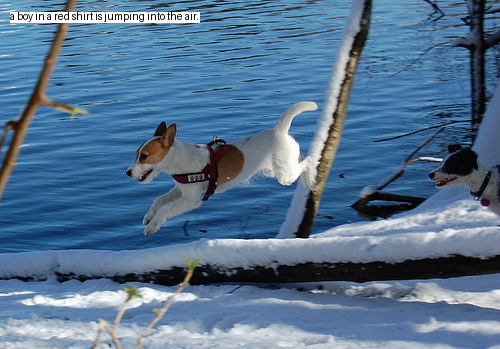

In [27]:
image = images_dataset[600]["image_path"]
image = Image.open(image).convert("RGB")
pixel_values = feature_extractor(images=image, return_tensors="pt").pixel_values.to(device)
output_ids = model.generate(pixel_values, max_length=cfg.MAX_LEN, num_beams=4, repetition_penalty=2.5)
caption = tokenizer.decode(output_ids[0], skip_special_tokens=True)

draw = ImageDraw.Draw(image)
font = ImageFont.load_default(10)
position = (10, 10)
bbox = draw.textbbox(position, caption, font=font)
draw.rectangle(bbox, fill="white")
draw.text(position, caption, font=font, fill="black")

image.show()

image

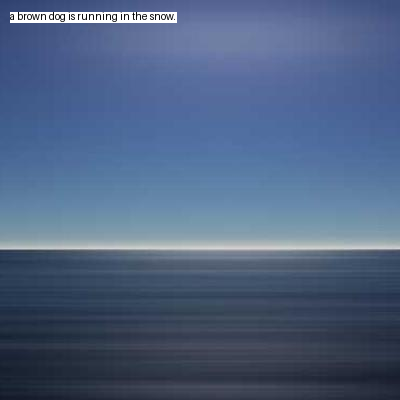

In [28]:
image_url = "https://picsum.photos/400"
image = Image.open(requests.get(image_url, stream=True).raw).convert("RGB")

pixel_values = feature_extractor(images=image, return_tensors="pt").pixel_values.to(device)
output_ids = model.generate(pixel_values, max_length=cfg.MAX_LEN, num_beams=4, repetition_penalty=2.5)
caption = tokenizer.decode(output_ids[0], skip_special_tokens=True)

draw = ImageDraw.Draw(image)
font = ImageFont.load_default(10)
position = (10, 10)
bbox = draw.textbbox(position, caption, font=font)
draw.rectangle(bbox, fill="white")
draw.text(position, caption, font=font, fill="black")


image